# 数据与可视化
我们先使用scikit-learn的make_classification函数产生一份分类数据，然后模拟一下拿到实际数据后我们需要做的事情。

In [1]:
import numpy as np
from sklearn.datasets import make_classification
X,y=make_classification(1000, n_features=20,n_informative=2,n_redundant=2,n_classes=2,random_state=0)

In [2]:
type(X)

numpy.ndarray

In [3]:
from pandas import DataFrame
df=DataFrame(np.hstack((X, y[:,None])),columns=list(range(20))+["class"])


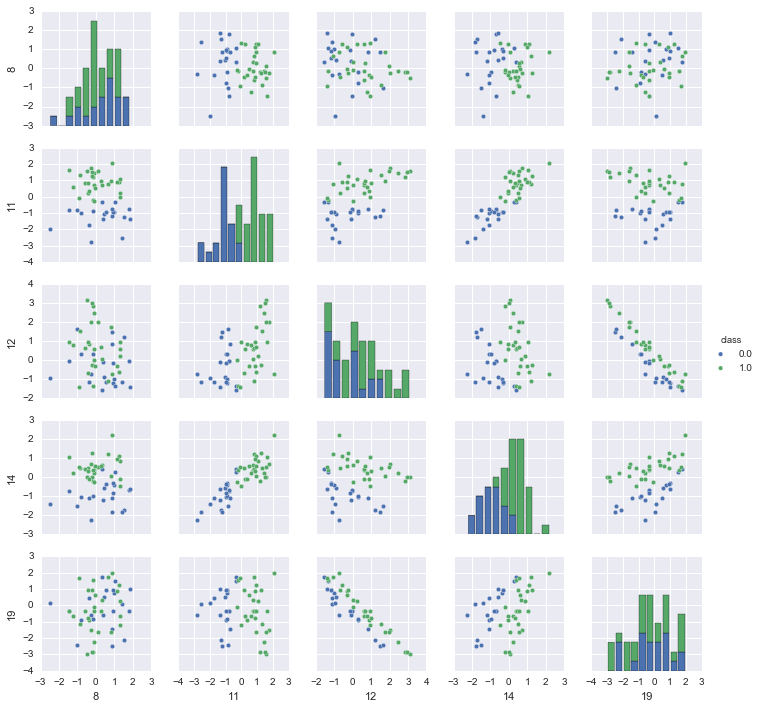

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.pairplot(df[:50],vars=[8,11,12,14,19],hue='class',size=2)

我们从散列图和柱状图上可以看出，确实有些维度的特征相对其他维度，有更好的区分度，比如第11维和14维看起来很有区分度。这两个维度上看，数据点是近似线性可分的。而12维和19维似乎呈现很高的负相关性。接下来我们用seanborn中的corrplot来计算计算各维度特征之间（以及最后的类别）的相关性。代码和结果图如下：

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/seaborn/linearmodels.py:1285: UserWarning: The `corrplot` function has been deprecated in favor of `heatmap` and will be removed in a forthcoming release. Please update your code.
  warnings.warn(("The `corrplot` function has been deprecated in favor "
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/seaborn/linearmodels.py:1351: UserWarning: The `symmatplot` function has been deprecated in favor of `heatmap` and will be removed in a forthcoming release. Please update your code.
  warnings.warn(("The `symmatplot` function has been deprecated in favor "


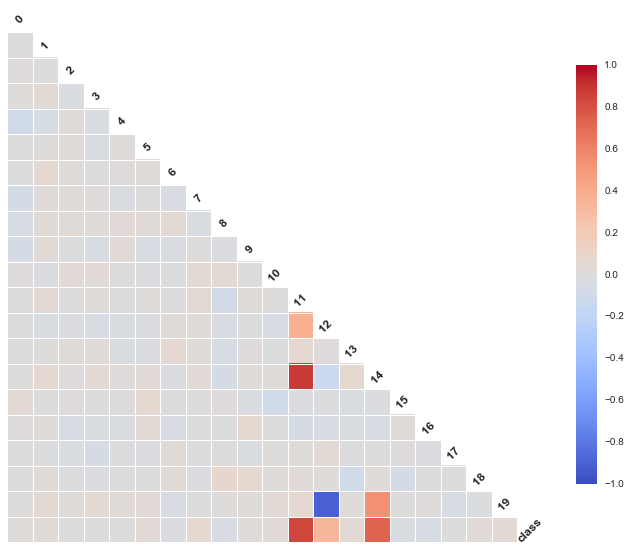

In [5]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12,10))
_=sns.corrplot(df,annot=False)
plt.show()

相关性图很好的印证了我们之间的想法，可以看到第11维特征和第14维特征和类别极强的相关性，同时它们俩之间也有极高的相关性。而第12维特征和第19维特征却呈现出极强的负相关性。强相关的特征其实包含了一些冗余的特征，而除掉上图中颜色较深的特征，其余特征包含的信息量就没有那么大了，它们和最后的类别相关度不高，甚至各自之间也没相关性。

插一句，这里的维度只有20，所以这个相关度计算并不太费大力气，然而实际情况中，你完全有可能有远高于这个数字的特征维度，同样样本量也可能多很多，那种情形下我们可能要先做一些处理，在来实现可视化了。

In [6]:
from sklearn.svm import LinearSVC
from sklearn.learning_curve import learning_curve
def plot_learning_curve(estimator, title, X,y,ylim=None, cv=None, 
                        train_sizes=np.linspace(.1,1.0,5)):
    plt.figure()
    train_sizes, train_scores,test_scores=learning_curve(
        estimator, X, y, cv=5, n_jobs=1, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores,axis=1)
    train_scores_std=np.std(train_scores,axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.fill_between(train_sizes, train_scores_mean-train_scores_std, 
                     train_scores_mean+train_scores_std, alpha=0.1, 
                     color='r')
    plt.fill_between(train_sizes, test_scores_mean-test_scores_std,
                     test_scores_mean+test_scores_std,alpha=0.1,
                     color='g')
    plt.plot(train_sizes, train_scores_mean, 'o-',color='r',
             label='Training Score')
    plt.plot(train_sizes,test_scores_mean,'o-',color='g',
             label='Cross-validation score')
    plt.xlabel('Training example')
    plt.ylabel('Score')
    plt.legend(loc='best')
    plt.grid('on')
    if ylim:
        plt.ylim(ylim)
    plt.title(title)
    plt.show()

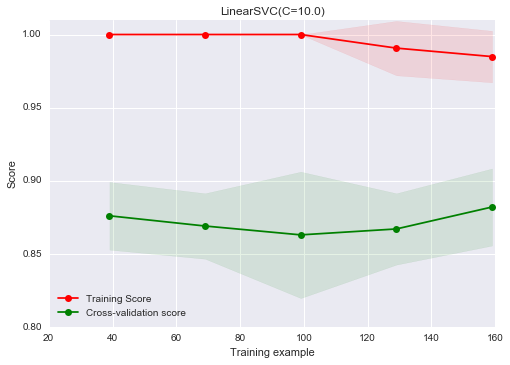

In [7]:
plot_learning_curve(LinearSVC(C=10.0), "LinearSVC(C=10.0)", X,y,ylim=(0.8,1.01),
                    train_sizes=np.linspace(0.05,0.2,5))

# 过拟合的定位与解决
## 增大样本量

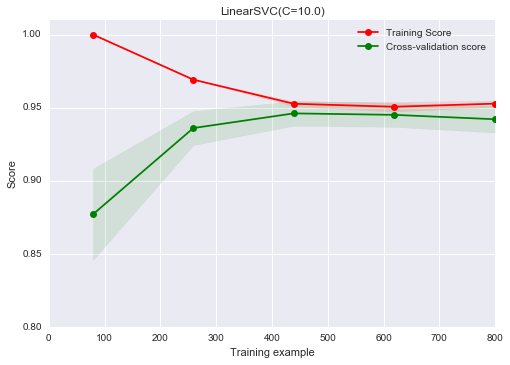

In [8]:
plot_learning_curve(LinearSVC(C=10.0), "LinearSVC(C=10.0)", X,y,ylim=(0.8,1.01),
                    train_sizes=np.linspace(0.1,1,5))

## 减少特征的量

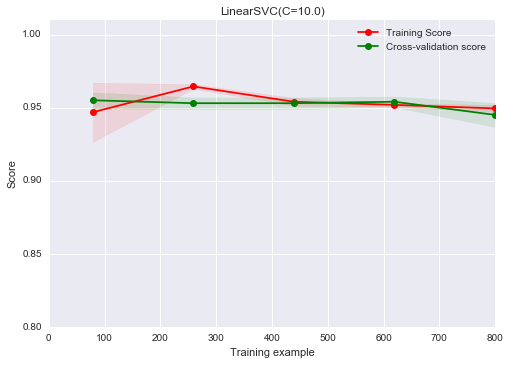

In [9]:
plot_learning_curve(LinearSVC(C=10.0), "LinearSVC(C=10.0)", X[:,[11,14]],y,ylim=(0.8,1.01),
                    train_sizes=np.linspace(0.1,1,5))

从上图上可以看出，过拟合问题也得到一定程度的缓和。不过我们这是我们自己观察后，手动选出11和14维特征。那能不能自动进行特征组合和选择呢，其实我们当然可以遍历特征的组合样式，然后再进行特征选择（前提依旧是这里特征的维度不高，如果高的话，遍历所有的组合式一个非常非常耗时的过程！！）

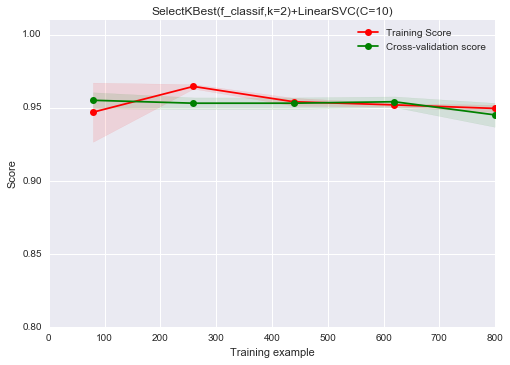

In [10]:
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, f_classif
plot_learning_curve(Pipeline([('fs', SelectKBest(f_classif,k=2)),
                                ('svc', LinearSVC(C=10.0))]), "SelectKBest(f_classif,k=2)+LinearSVC(C=10)", X,y,ylim=(0.8,1.01),train_sizes=np.linspace(0.1,1,5))

跑一下程序发现这个过程很顺利，主要还是因为我手造的这份数据，这个特征选择的过程超级顺利，但依旧像我们之前提过的一样，这是因为特征的维度不太高。
从另外一个角度看，我们之所以做特征选择，是想降低模型的复杂度，而更不容易刻画到噪声数据的分布。 从这个角度出发，我们还可以有（1）多项式拟合模型中降低多项式次数。
（2）神经网络中减少神经网络的层数和每层的节点数（3）SVM中增加RBFkernal的bandwidth等方式来降低模型的复杂度。

## 增强正则化作用（比如这里是减少LinearSVC中的C参数）
正则化是在不损失信息的情况下，最有效的缓解过拟合现象的方法。

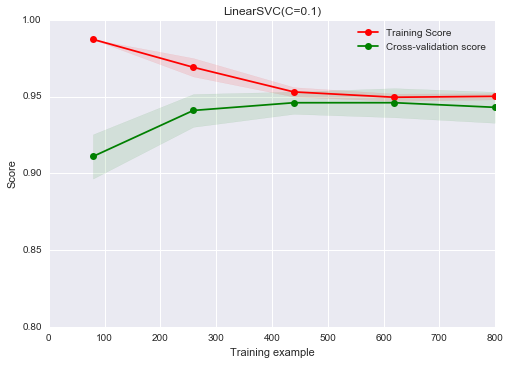

In [11]:
plot_learning_curve(LinearSVC(C=0.1), "LinearSVC(C=0.1)", X,y,ylim=(0.8, 1.0), train_sizes=np.linspace(0.1,1,5))

调整正则化系数后，发现的确过拟合现象有一定程度的缓解，但依旧是那个问题，我们现在的系数是自己搞定的，有没有方法可以自动选择最佳的这个参数呢？ 可以，我们可以在交叉验证集赏做gridsearch 查找最好的正则化系数（对于大数据样本，我们依旧需要考虑时间问题，这个过程可能会比较慢）：

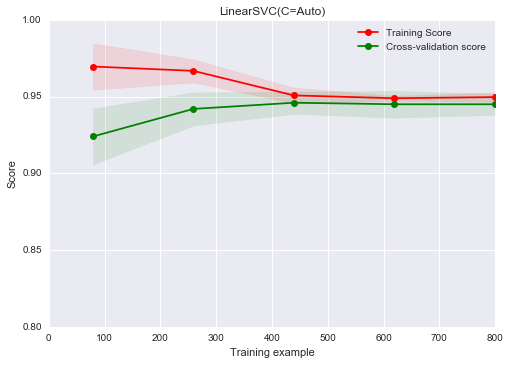

{'C': 0.01}

In [12]:
from sklearn.grid_search import GridSearchCV
estm=GridSearchCV(LinearSVC(), 
                  param_grid={"C":[0.001,0.01,0.1,1.0,10.0]})
plot_learning_curve(estm, "LinearSVC(C=Auto)", 
                     X,y,ylim=(0.8,1.0),
                     train_sizes=np.linspace(.1,1,5))
estm.fit(X,y).best_params_

对于特征选择的部分，我打算多少几句，我们刚才看过了用sklearn.feature_selection中的SelectKBest来选特征的过程，也提高了在高维特征的情况下，这个过程可能会非常慢。那我们有别的办法可以进行特征选择吗？比如说，我们的分类器自己能否甄别那些特征是对最后的结果有益的？这个有个实际工作中用到的小技巧。

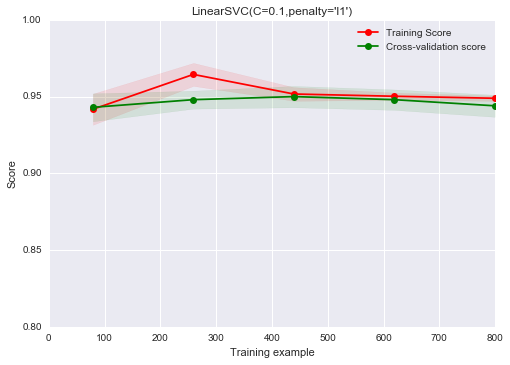

In [13]:
plot_learning_curve(LinearSVC(C=0.1, penalty='l1', dual=False), 
                    "LinearSVC(C=0.1,penalty='l1')", X,y,ylim=(0.8,1.0),
                      train_sizes=np.linspace(0.1,1,5))

In [14]:
estm=LinearSVC(C=0.1,penalty='l1',dual=False)
estm.fit(X,y)
estm.coef_

array([[ 0.00749747, -0.03198765, -0.03389249, -0.04451438,  0.0016742 ,
         0.03337418,  0.        ,  0.04562389,  0.00928554, -0.01049767,
         0.03474118,  1.160055  ,  0.15812594, -0.00494465,  0.        ,
         0.        ,  0.01223332, -0.01029244,  0.00720071,  0.        ]])

## 过拟合定位与解决

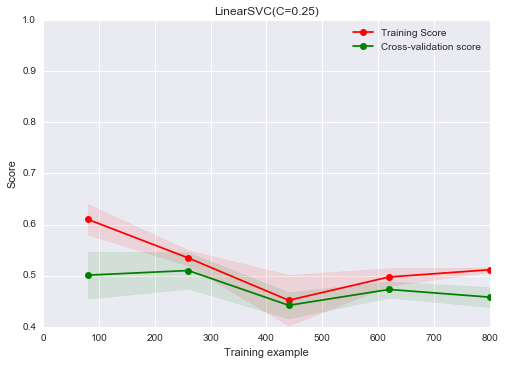

In [15]:
from sklearn.datasets import make_circles
X,y=make_circles(n_samples=1000,random_state=2)
plot_learning_curve(LinearSVC(C=0.25), "LinearSVC(C=0.25)",X,y,
                     ylim=(0.4,1),train_sizes=np.linspace(0.1,1,5))

简直太烂了，有没有，而分类问题，我们做随机猜测，准确率都有0.5，这比随机猜测都高不了多少

In [16]:
f=DataFrame(np.hstack((X,y[:,None])),columns=list(range(2))+['class'])

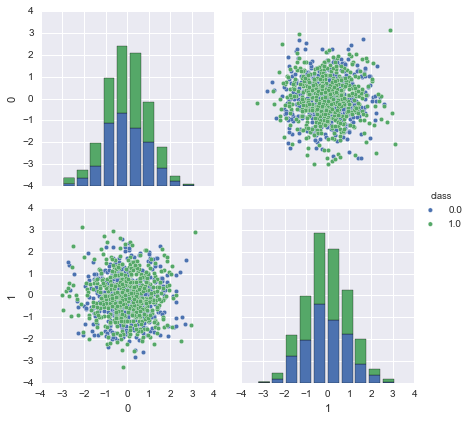

In [17]:
sns.pairplot(df,vars=[0,1],hue='class',size=3)

## 调整特征（create new features）

In [18]:
X_extra = np.hstack((X,X[:,[0]]**2 + X[:,[1]]**2))

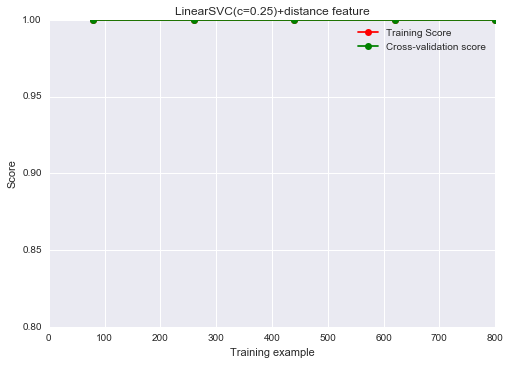

In [19]:
plot_learning_curve(LinearSVC(C=0.25),'LinearSVC(c=0.25)+distance feature',X_extra,y,ylim=(0.8,1)
                    ,train_sizes=np.linspace(0.1,1,5))

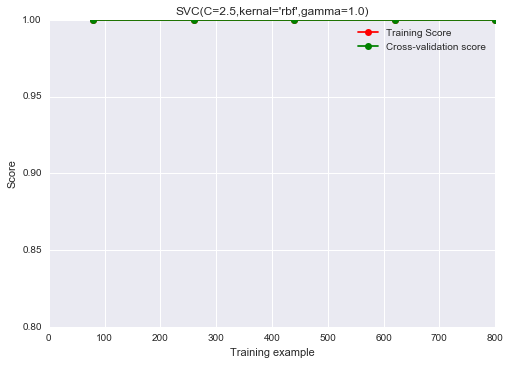

In [20]:
from sklearn.svm import SVC
plot_learning_curve(SVC(C=2.5, kernel='rbf',gamma=1.0), "SVC(C=2.5,kernal='rbf',gamma=1.0)", 
                    X,y,ylim=(0.8,1), train_sizes=np.linspace(0.1,1,5))

## 大数据样本集和高维特征空间
我们在小样本的toy dataset上， 怎么捣鼓都有好的方法。但是当数据量和特征样本空间膨胀非常厉害时，很多东西都没有那么好使了，至少时一个很耗时的过程。举个例子说，我们现在重新生成一分数据集，但是这次，我们生成更多的数据，更高的特征维度，而分类的类别也提高到5.

大数据情况下的模型选择与学习曲线

从上面提到的那份数据，我们用LinearSVC可能就会慢了，我们注意到机器学习算法推荐我们使用图谱推荐我们使用SGDClassifier. 其实本质上说，这个模型也是一个线性核函数的模型，不同的地方是，它使用了随机梯度下降做训练， 所以每次并没有使用全部的样本，收敛速度会快很多。再多提一点， SGDClassifier对于特征的幅度非常敏感，也就是说，我们在数据灌给它之间，应该先对特征做幅度调整，当然，用sklearn的StandardScaler可以很方便地 完成这一点。

StandardScaler 每次只使用一部分（mini－batch）做训练，在这种情况下，我们使用交叉验证病不是恨合适，我们会使用相对应的progressive validation：简单解释一下，estimate每次只会拿下一个待训练batch在本次做评估，然后训练完以后，再在这个batch上做一次评估，看看是否优化。

In [21]:
import numpy as np
from sklearn.datasets import make_classification
X,y=make_classification(200000, n_features=200,n_informative=25,n_redundant=0,n_classes=10,class_sep=2,random_state=0)

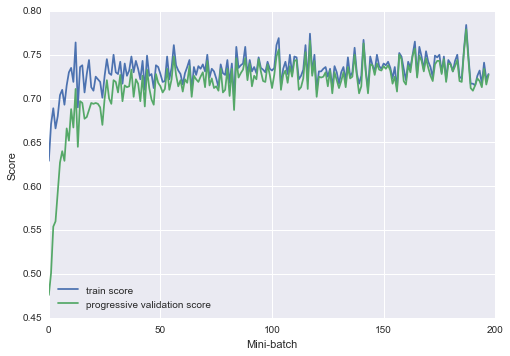

In [22]:
from sklearn.linear_model import SGDClassifier
est = SGDClassifier(penalty='l1',alpha=0.001)
progressive_validation_score=[]
train_score=[]
for datapoint in range(0, 199000,1000):
    X_batch=X[datapoint:datapoint+1000]
    y_batch=y[datapoint:datapoint+1000]
    if datapoint > 0:
        progressive_validation_score.append(est.score(X_batch, y_batch))
    est.partial_fit(X_batch, y_batch,classes=range(10))
    if datapoint > 0: 
        train_score.append(est.score(X_batch, y_batch))
plt.plot(train_score, label='train score')
plt.plot(progressive_validation_score, label='progressive validation score')
plt.xlabel('Mini-batch')
plt.ylabel('Score')
plt.legend(loc='best')
plt.show()

从这个图上的得分，我们可以看出在50个mini－batch迭代之后，数据上的得分就已经变化不太大。但是好像得分不太高，所以我们猜测一下，这个时候我们的数据，处于欠拟合状态。

## 大数据量下的可视化

## 损失函数的选择

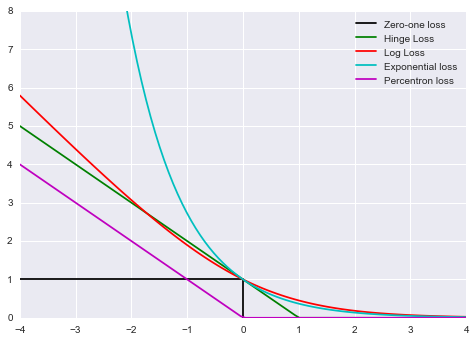

In [23]:
import numpy as np
import matplotlib.pyplot as plt
xmin, xmax = -4, 4
xx = np.linspace(xmin, xmax, 100)
plt.plot([xmin,0,0,xmax], [1,1,0,0], 'k-',
         label='Zero-one loss')
plt.plot(xx, np.where(xx<1,1-xx,0),'g-',label='Hinge Loss')
plt.plot(xx, np.log2(1+np.exp(-xx)), 'r-', label='Log Loss')
plt.plot(xx, np.exp(-xx), 'c-', label="Exponential loss")
plt.plot(xx, -np.minimum(xx,0), 'm-', label='Percentron loss')
plt.ylim((0,8))
plt.legend(loc='upper right')
plt.ylabel("")

不同的损失函数有不同的优缺点：

- 0-1 损失函数（zero－one loss）非常好理解，直接对应分类问题中判断的个数。但是尴尬的是它是一个非凸函数， 这一位着其实不是那么实用。
- hinge loss（SVM中使用到的）的健壮性相对性比较高（对异常点／噪声不敏感）。但是他没有那么好的解释概率。
- log损失函数（log-loss）的结果能非常好地表征概率分布。因此在很多场景，尤其是多分类场景下，如果我们需要知道结果属于每个类别的置信度，那这个损失函数很适合。缺点是他的健壮性没有那么强，相对hinge loss会对噪声敏感些。
- 多项式损失函数（exponential loss）(AdaBoost 中用到的)对离群点／噪声非常非常敏感。但是boosting算法简单而有效。
- 感知损失（perceptro loss）可以看做时hinger loss 的一个变种。hinge loss 对于判定边界附近的店惩罚力度很高。而perception loss， 只要样本的判定类别结果是正确的，他就是满意的，而不管其判定边界的距离。优点是笔hinge loss简单，缺点是因为不是Max-margin boundary, 所以得到模型的泛化能力没有hinge loss强。
